In [ ]:
!pip install transformers datasets torch sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# mount google drive to access/load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import T5Tokenizer
from datasets import Dataset
import json

# Load the dataset
def load_data(file_path):
    articles = []
    summaries = []
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            # First join words in each sentence, then join sentences in each paragraph
            article_text = ' '.join([' '.join(sentence) for paragraph in data['paragraphs'] for sentence in paragraph])
            summary_text = ' '.join([' '.join(sentence) for sentence in data['summary']])

            articles.append(article_text)
            summaries.append(summary_text)
    return articles, summaries

# Paths to dataset JSONL files
train_file = '/content/drive/MyDrive/Dataset/indosum/train.01.jsonl'
dev_file = '/content/drive/MyDrive/Dataset/indosum/dev.01.jsonl'
test_file = '/content/drive/MyDrive/Dataset/indosum/test.01.jsonl'

# Load data
train_articles, train_summaries = load_data(train_file)
dev_articles, dev_summaries = load_data(dev_file)
test_articles, test_summaries = load_data(test_file)

# Create a Hugging Face Dataset
train_dataset = Dataset.from_dict({"document": train_articles, "summary": train_summaries})
dev_dataset = Dataset.from_dict({"document": dev_articles, "summary": dev_summaries})
test_dataset = Dataset.from_dict({"document": test_articles, "summary": test_summaries})


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

# Preprocessing function
def preprocess_data(examples):
    prefix = "summarize: "  # Prefix for T5-style summarization
    inputs = [prefix + doc for doc in examples['document']]
    targets = examples['summary']

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=150, truncation=True, padding="max_length")

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize datasets
tokenized_train_dataset = train_dataset.map(preprocess_data, batched=True)
tokenized_dev_dataset = dev_dataset.map(preprocess_data, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_data, batched=True)

# Save memory by removing unused columns
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["document", "summary"])
tokenized_dev_dataset = tokenized_dev_dataset.remove_columns(["document", "summary"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["document", "summary"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/14262 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/3762 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

# Load IndoT5 model
# model = T5ForConditionalGeneration.from_pretrained("LazarusNLP/IndoNanoT5-base")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    # predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=500
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_dev_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-ad4ea0bbd598>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.954800,0.605352
2,0.664300,0.552764
3,0.624400,0.538130


TrainOutput(global_step=5349, training_loss=1.5965452367155368, metrics={'train_runtime': 4715.7463, 'train_samples_per_second': 9.073, 'train_steps_per_second': 1.134, 'total_flos': 2.262308427399168e+16, 'train_loss': 1.5965452367155368, 'epoch': 3.0})

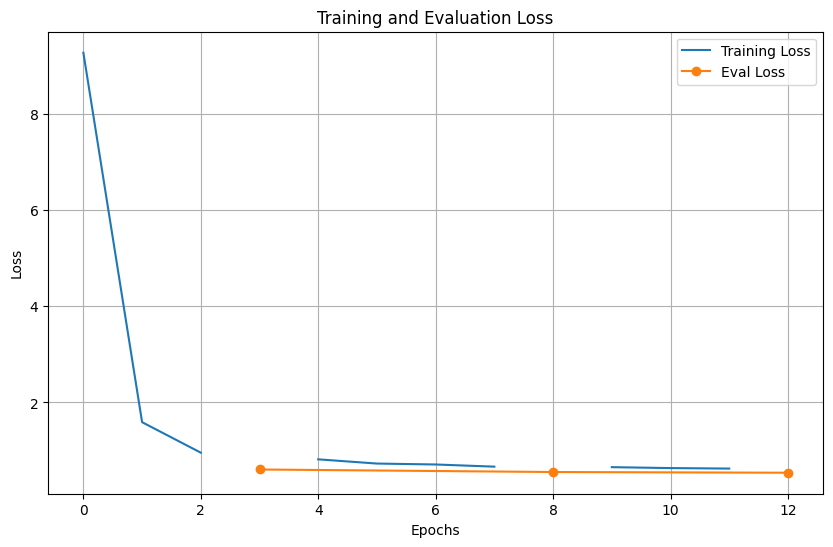

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'trainer' is your Trainer object from the previous code

# Access training history
train_history = trainer.state.log_history

# Extract relevant metrics (e.g., loss, learning rate)
epochs = [i for i in range(len(train_history))]
training_loss = [entry.get("loss") for entry in train_history]
eval_loss = [entry.get("eval_loss") for entry in train_history if entry.get("eval_loss") is not None]
eval_epochs = [i for i, entry in enumerate(train_history) if entry.get("eval_loss") is not None]

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(eval_epochs, eval_loss, label='Eval Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot other metrics if available in train_history
# For example, learning rate:
# learning_rate = [entry.get("learning_rate") for entry in train_history]
# plt.plot(epochs, learning_rate, label='Learning Rate')

In [ ]:
!cp -r /content/IndoT5/results/checkpoint-5349 /content/drive/MyDrive/Model/NLP

In [ ]:
def generate_summaries(articles, model, tokenizer, max_input_length=512, max_output_length=150):
    summaries = []
    for article in articles:
        # Tokenize input
        inputs = tokenizer(
            article, max_length=max_input_length, truncation=True, return_tensors="pt"
        )

        # Move inputs to the same device as the model
        inputs = inputs.to(model.device)  # Add this line

        # Generate summary
        outputs = model.generate(
            inputs.input_ids,
            max_length=max_output_length,
            num_beams=4,  # Use beam search for better quality
            early_stopping=True,
        )

        # Decode output
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

In [ ]:
# Assuming test_articles is a list of article texts
test_summaries_generated = generate_summaries(test_articles[:100], model, tokenizer)

In [ ]:
for i in range(5):
  print(f"Input : {test_articles[i]}")
  print(f"Generated : {test_summaries_generated[i]}")
  print(f"Reference : {test_summaries[i]}")
  print()

Input : Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawatan setelah menjalankan operasi menurunkan badan di India . Eman Ahmed Abd El Aty memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di Mumbai Maret lalu dimana ia mengurangi seperlima dari berat badannya . Ia menderita berbagai macam masalah kesehatan termasuk penyakit gajah , kondisi yang menyebabkan anggota badan membengkak . Abd El Aty diberi diet cairan khusus selama berada di India yang bertujuan menurunkan berat badan . Diet ini memungkinkan dokter melakukan operasi bariatrik , prosedur bypass yang kini sering dilakukan di India dalam menghadapi masalah obesitas yang bertambah banyak . Ia tiba di India dengan menggunakan pesawat Airbus yang secara khusus telah dimodifikasi khusus untuk mengangkutnya pada bulan Februari . Kini , berat badannya telah turun 

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a281d43dfe130f38deca411768f6960470c257da009347bbe0d2a3030886fc46
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer
import numpy as np

def compute_rouge(reference_summaries, generated_summaries):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    for ref, gen in zip(reference_summaries, generated_summaries):
        scores = scorer.score(ref, gen)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rouge2_scores.append(scores["rouge2"].fmeasure)
        rougeL_scores.append(scores["rougeL"].fmeasure)

    # Return average scores
    return {
        "rouge1": np.mean(rouge1_scores),
        "rouge2": np.mean(rouge2_scores),
        "rougeL": np.mean(rougeL_scores),
    }

# Evaluate summaries
rouge_scores = compute_rouge(test_summaries, test_summaries_generated)
print("ROUGE Scores:", rouge_scores)

ROUGE Scores: {'rouge1': 0.5899551748398462, 'rouge2': 0.4965881992103086, 'rougeL': 0.5379907618765002}


In [ ]:
# prompt: save the generated summaries and rouge score variable with pickle

import pickle

# ... (Your existing code) ...

# Assuming test_summaries_generated and rouge_scores are defined as in your code

# Save the generated summaries and ROUGE scores using pickle
with open('/content/drive/MyDrive/Model/NLP/summaries_and_scores.pkl', 'wb') as f:
    pickle.dump({
        'generated_summaries': test_summaries_generated,
        'rouge_scores': rouge_scores
    }, f)

#To load the data later:
# with open('summaries_and_scores.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
#     loaded_summaries = loaded_data['generated_summaries']
#     loaded_scores = loaded_data['rouge_scores']